## Stock Price Prediction Using Long Short-Term Memory (LSTM)

In this project we are going to predict stock prices using **Long Short-Term Memory (LSTM)**, a variant of **Recurrent Neural Network (RNN)**. More specifically, we are going to build an LSTM model which will predict the daily closing price of **Grameenphone (GP)**, a telecom operator enlisted in **Dhaka Stock Exchange (DSE)**, based on its historical stock data.

For the time being, we will train the model on the historical data of 2019 and make prediction on the data of 2020. We will use data of January 2020 as `validation set` and data of February 2020 as `test set`. Data Source: https://www.dsebd.org/

In [87]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
# Import training data
df_train_all = pd.read_json("./data/dse-dataset/prices_2019.json")
df_train_all.shape

(138291, 11)

In [89]:
# View first 5 instances
df_train_all.head()

,date,trading_code,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
0,2019-12-30,1JANATAMF,4.3,4.3,4.2,4.2,4.3,4.2,29,0.898,208957
1,2019-12-29,1JANATAMF,4.2,4.3,4.2,4.2,4.2,4.3,33,1.215,289149
2,2019-12-26,1JANATAMF,4.3,4.3,4.2,4.2,4.3,4.2,13,0.172,40362
3,2019-12-24,1JANATAMF,4.2,4.3,4.2,4.2,4.2,4.2,34,0.839,199583
4,2019-12-23,1JANATAMF,4.3,4.3,4.2,4.2,4.2,4.2,34,0.969,230775


In [90]:
# Get basic information about data
df_train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138291 entries, 0 to 138290
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   date                      138291 non-null  datetime64[ns]
 1   trading_code              138291 non-null  object        
 2   last_traded_price         138291 non-null  float64       
 3   high                      138291 non-null  float64       
 4   low                       138291 non-null  float64       
 5   opening_price             138291 non-null  float64       
 6   closing_price             138291 non-null  float64       
 7   yesterdays_closing_price  138291 non-null  float64       
 8   trade                     138291 non-null  int64         
 9   value_mn                  138291 non-null  float64       
 10  volume                    138291 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usag

In [91]:
# Checking if there is any null values
df_train_all.isna().sum()

date                        0
trading_code                0
last_traded_price           0
high                        0
low                         0
opening_price               0
closing_price               0
yesterdays_closing_price    0
trade                       0
value_mn                    0
volume                      0
dtype: int64

In [92]:
# Get the unique companies along with the number of their instances
df_train_all.trading_code.value_counts()

DOREENPWR     243
DEBARACEM     237
T5Y0616       237
T10Y0214      237
T20Y0828      237
             ... 
SILCOPHL      132
SEAPEARL      110
ICB2NDNRB     101
COPPERTECH     96
RINGSHINE      11
Name: trading_code, Length: 588, dtype: int64

In [93]:
# Get the list of unique companies
df_train_all.trading_code.unique()

array(['1JANATAMF', '1STPRIMFMF', 'AAMRANET', 'AAMRATECH', 'ABB1STMF',
       'ABBANK', 'ACFL', 'ACI', 'ACIFORMULA', 'ACMELAB', 'ACTIVEFINE',
       'ADVENT', 'AFCAGRO', 'AFTABAUTO', 'AGNISYSL', 'AGRANINS',
       'AIBL1STIMF', 'AIL', 'AL-HAJTEX', 'ALARABANK', 'ALIF', 'ALLTEX',
       'AMANFEED', 'AMBEEPHA', 'AMCL(PRAN)', 'ANLIMAYARN', 'ANWARGALV',
       'APEXFOODS', 'APEXFOOT', 'APEXSPINN', 'APEXTANRY', 'APOLOISPAT',
       'ARAMIT', 'ARAMITCEM', 'ARGONDENIM', 'ASIAINS', 'ASIAPACINS',
       'ATCSLGF', 'ATLASBANG', 'AZIZPIPES', 'BANGAS', 'BANKASIA',
       'BARKAPOWER', 'BATASHOE', 'BATBC', 'BAYLEASING', 'BBS',
       'BBSCABLES', 'BDAUTOCA', 'BDCOM', 'BDFINANCE', 'BDLAMPS',
       'BDSERVICE', 'BDTHAI', 'BDWELDING', 'BEACHHATCH', 'BEACONPHAR',
       'BENGALWTL', 'BERGERPBL', 'BEXIMCO', 'BGIC', 'BIFC', 'BNICL',
       'BPML', 'BRACBANK', 'BSC', 'BSCCL', 'BSRMLTD', 'BSRMSTEEL',
       'BXPHARMA', 'BXSYNTH', 'CAPMBDBLMF', 'CAPMIBBLMF', 'CENTRALINS',
       'CENTRALPHL', 'CITYBANK', 'C

In this project we are particularly interseted in the stock price of **Grameenphone (GP)**. So, let's solely focus on it.

In [94]:
# Check whether the trading code of Grameenphone (GP) is present or not
list(df_train_all.trading_code.unique()).count("GP")

1

In [95]:
# Get total number of instances of GP
len(df_train_all[df_train_all.trading_code == 'GP'])

237

In [96]:
# Check if there is any missing value of GP
df_train_all[df_train_all.trading_code == "GP"].isna().sum()

date                        0
trading_code                0
last_traded_price           0
high                        0
low                         0
opening_price               0
closing_price               0
yesterdays_closing_price    0
trade                       0
value_mn                    0
volume                      0
dtype: int64

In [97]:
# Discard all the trading codes except GP
df_train = df_train_all[df_train_all.trading_code == "GP"]
df_train

,date,trading_code,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
33427,2019-12-30,GP,286.0,286.5,285.0,285.8,285.8,285.8,442,47.785,167117
33428,2019-12-29,GP,286.4,287.5,284.3,284.3,285.8,286.9,491,32.634,114279
33429,2019-12-26,GP,287.0,289.9,284.0,288.0,286.9,287.2,483,36.503,127084
33430,2019-12-24,GP,287.0,292.3,285.0,285.0,287.2,288.8,349,27.359,95269
33431,2019-12-23,GP,286.3,296.0,275.5,284.2,288.8,284.2,1567,88.911,310361
...,...,...,...,...,...,...,...,...,...,...,...
33659,2019-01-07,GP,372.8,376.0,371.3,375.0,372.1,373.0,1334,177.380,474937
33660,2019-01-06,GP,372.3,373.5,367.7,367.7,373.0,365.4,1108,48.225,129676
33661,2019-01-03,GP,367.0,368.7,364.2,365.0,365.4,365.6,1063,49.907,136490
33662,2019-01-02,GP,366.1,368.0,364.5,368.0,365.6,368.3,690,24.506,67018


In [98]:
# Discard unnecessary column
df_train = df_train.drop("trading_code", axis=1)
df_train

,date,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
33427,2019-12-30,286.0,286.5,285.0,285.8,285.8,285.8,442,47.785,167117
33428,2019-12-29,286.4,287.5,284.3,284.3,285.8,286.9,491,32.634,114279
33429,2019-12-26,287.0,289.9,284.0,288.0,286.9,287.2,483,36.503,127084
33430,2019-12-24,287.0,292.3,285.0,285.0,287.2,288.8,349,27.359,95269
33431,2019-12-23,286.3,296.0,275.5,284.2,288.8,284.2,1567,88.911,310361
...,...,...,...,...,...,...,...,...,...,...
33659,2019-01-07,372.8,376.0,371.3,375.0,372.1,373.0,1334,177.380,474937
33660,2019-01-06,372.3,373.5,367.7,367.7,373.0,365.4,1108,48.225,129676
33661,2019-01-03,367.0,368.7,364.2,365.0,365.4,365.6,1063,49.907,136490
33662,2019-01-02,366.1,368.0,364.5,368.0,365.6,368.3,690,24.506,67018


In [99]:
# Sort instances by ascending order of date
df_train.sort_values(by=["date"], inplace=True, ascending=True)
df_train.date.head(20)

33663   2019-01-01
33662   2019-01-02
33661   2019-01-03
33660   2019-01-06
33659   2019-01-07
33658   2019-01-08
33657   2019-01-09
33656   2019-01-10
33655   2019-01-13
33654   2019-01-14
33653   2019-01-15
33652   2019-01-16
33651   2019-01-17
33650   2019-01-20
33649   2019-01-21
33648   2019-01-22
33647   2019-01-23
33646   2019-01-24
33645   2019-01-27
33644   2019-01-28
Name: date, dtype: datetime64[ns]

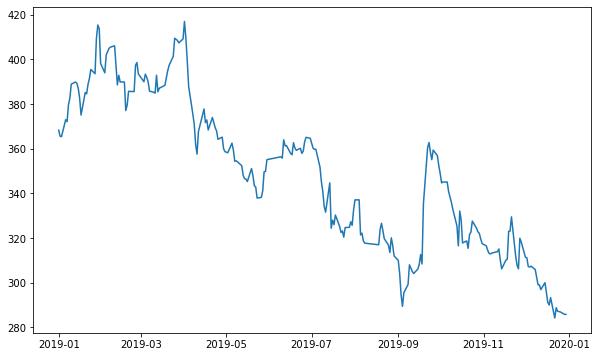

In [100]:
# Plot closing_price with respect to date
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_train.date, df_train.closing_price);

In [101]:
# Add datetime parameters for date (i.e. extracting information from date and making columns with them)
df_train["year"] = df_train.date.dt.year
df_train["month"] = df_train.date.dt.month
df_train["day"] = df_train.date.dt.day
df_train["day_of_week"] = df_train.date.dt.dayofweek
df_train["day_of_year"] = df_train.date.dt.dayofyear

# Drop original date
df_train.drop("date", axis=1, inplace=True)

# View first 5 instances
df_train.head()

,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume,year,month,day,day_of_week,day_of_year
33663,365.0,376.0,363.0,370.0,368.3,367.3,788,35.064,94877,2019,1,1,1,1
33662,366.1,368.0,364.5,368.0,365.6,368.3,690,24.506,67018,2019,1,2,2,2
33661,367.0,368.7,364.2,365.0,365.4,365.6,1063,49.907,136490,2019,1,3,3,3
33660,372.3,373.5,367.7,367.7,373.0,365.4,1108,48.225,129676,2019,1,6,6,6
33659,372.8,376.0,371.3,375.0,372.1,373.0,1334,177.380,474937,2019,1,7,0,7


In [102]:
# Keep a backup of the dataFrame
df_train_backup = df_train.copy()

For the time being we will use the data of January (2020) for validation and the data of February (2020) for testing.

In [103]:
# Import data of 2020
df_2020_all = pd.read_json("./data/dse-dataset/prices_2020.json")
df_2020_all.shape

(116743, 11)

In [104]:
# View first 5 instances
df_2020_all.head()

,date,trading_code,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
0,2020-12-30,1JANATAMF,6.0,6.1,5.9,6.1,6.0,6.0,271,7.694,1287797
1,2020-12-29,1JANATAMF,6.1,6.3,6.0,6.2,6.0,6.1,244,8.189,1348470
2,2020-12-28,1JANATAMF,6.1,6.2,5.9,5.9,6.1,5.9,339,14.594,2424350
3,2020-12-27,1JANATAMF,5.9,6.0,5.8,5.9,5.9,5.8,219,7.333,1241056
4,2020-12-24,1JANATAMF,5.8,5.9,5.6,5.6,5.8,5.7,194,4.993,869684


In [105]:
# Check whether the trading code of Grameenphone (GP) is present or not
list(df_2020_all.trading_code.unique()).count("GP")

1

In [106]:
# Get total number of instances of GP
len(df_2020_all[df_2020_all.trading_code == 'GP'])

208

In [107]:
# Check if there is any missing value of GP
df_2020_all[df_2020_all.trading_code == "GP"].isna().sum()

date                        0
trading_code                0
last_traded_price           0
high                        0
low                         0
opening_price               0
closing_price               0
yesterdays_closing_price    0
trade                       0
value_mn                    0
volume                      0
dtype: int64

In [108]:
# Discard all the trading codes except GP
df_2020 = df_2020_all[df_2020_all.trading_code == "GP"]
df_2020

,date,trading_code,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
30085,2020-12-30,GP,347.1,349.9,346.0,349.9,347.1,349.7,1214,92.159,265172
30086,2020-12-29,GP,349.7,353.5,348.0,353.0,349.7,353.7,895,87.945,251447
30087,2020-12-28,GP,353.1,355.1,347.0,350.5,353.7,350.0,1813,168.995,479780
30088,2020-12-27,GP,350.0,351.9,342.0,344.0,350.0,341.1,1313,97.598,280688
30089,2020-12-24,GP,341.1,343.9,337.2,337.5,341.1,337.2,892,89.219,262224
...,...,...,...,...,...,...,...,...,...,...,...
30288,2020-01-07,GP,272.7,278.0,271.0,275.0,272.0,275.0,510,15.667,57353
30289,2020-01-06,GP,273.1,285.8,271.4,285.8,275.0,282.4,1032,36.539,132678
30290,2020-01-05,GP,282.0,285.0,281.8,283.5,282.4,282.9,293,8.361,29546
30291,2020-01-02,GP,283.0,290.0,281.1,281.8,282.9,281.4,628,72.308,254251


In [109]:
# Discard unnecessary column
df_2020 = df_2020.drop("trading_code", axis=1)
df_2020

,date,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
30085,2020-12-30,347.1,349.9,346.0,349.9,347.1,349.7,1214,92.159,265172
30086,2020-12-29,349.7,353.5,348.0,353.0,349.7,353.7,895,87.945,251447
30087,2020-12-28,353.1,355.1,347.0,350.5,353.7,350.0,1813,168.995,479780
30088,2020-12-27,350.0,351.9,342.0,344.0,350.0,341.1,1313,97.598,280688
30089,2020-12-24,341.1,343.9,337.2,337.5,341.1,337.2,892,89.219,262224
...,...,...,...,...,...,...,...,...,...,...
30288,2020-01-07,272.7,278.0,271.0,275.0,272.0,275.0,510,15.667,57353
30289,2020-01-06,273.1,285.8,271.4,285.8,275.0,282.4,1032,36.539,132678
30290,2020-01-05,282.0,285.0,281.8,283.5,282.4,282.9,293,8.361,29546
30291,2020-01-02,283.0,290.0,281.1,281.8,282.9,281.4,628,72.308,254251


In [110]:
# Sort instances by ascending order of date
df_2020.sort_values(by=["date"], inplace=True, ascending=True)
df_2020.date.head(20)

30292   2020-01-01
30291   2020-01-02
30290   2020-01-05
30289   2020-01-06
30288   2020-01-07
30287   2020-01-08
30286   2020-01-09
30285   2020-01-12
30284   2020-01-13
30283   2020-01-14
30282   2020-01-15
30281   2020-01-16
30280   2020-01-19
30279   2020-01-20
30278   2020-01-21
30277   2020-01-22
30276   2020-01-23
30275   2020-01-26
30274   2020-01-27
30273   2020-01-28
Name: date, dtype: datetime64[ns]

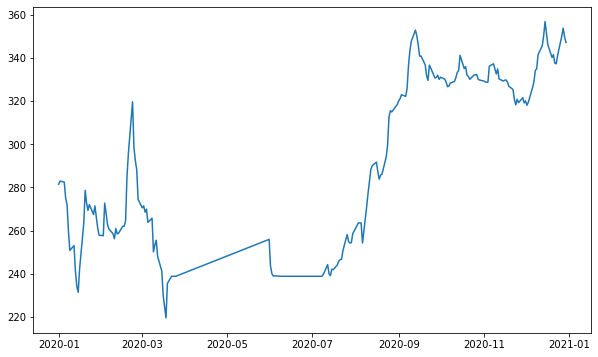

In [111]:
# Plot closing_price with respect to date
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_2020.date, df_2020.closing_price);

In [112]:
# Add datetime parameters for date (i.e. extracting information from date and making columns with them)
df_2020["year"] = df_2020.date.dt.year
df_2020["month"] = df_2020.date.dt.month
df_2020["day"] = df_2020.date.dt.day
df_2020["day_of_week"] = df_2020.date.dt.dayofweek
df_2020["day_of_year"] = df_2020.date.dt.dayofyear

# Drop original date
df_2020.drop("date", axis=1, inplace=True)

# View first 5 instances
df_2020.head()

,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume,year,month,day,day_of_week,day_of_year
30292,283.0,287.0,280.0,280.0,281.4,285.8,673,18.901,66791,2020,1,1,2,1
30291,283.0,290.0,281.1,281.8,282.9,281.4,628,72.308,254251,2020,1,2,3,2
30290,282.0,285.0,281.8,283.5,282.4,282.9,293,8.361,29546,2020,1,5,6,5
30289,273.1,285.8,271.4,285.8,275.0,282.4,1032,36.539,132678,2020,1,6,0,6
30288,272.7,278.0,271.0,275.0,272.0,275.0,510,15.667,57353,2020,1,7,1,7


In [113]:
# Keep a backup of the dataFrame
df_2020_backup = df_2020.copy()

In [114]:
# Get the number of trading days of January and February of 2020
num_days_jan = len(df_2020[df_2020.month==1])
num_days_feb = len(df_2020[df_2020.month==2])
num_days_jan, num_days_feb

(22, 20)

In [115]:
# Split data
X_train = df_train.drop("closing_price", axis=1)
y_train = df_train["closing_price"]

data_valid = df_2020[:22]
data_test = df_2020[22:42]

X_valid = data_valid.drop("closing_price", axis=1)
y_valid = data_valid["closing_price"]

X_test = data_test.drop("closing_price", axis=1)
y_test = data_test["closing_price"]

# Get the shape of splitted train, validation and test data
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((237, 13), (237,), (22, 13), (22,), (20, 13), (20,))

**Reshape data**

We need to reshape our data before feeding it to LSTM.

In [116]:
# Convert dataFrame into arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Convert features into three dimensions
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_valid = np.reshape(X_valid, (X_valid.shape[0],X_valid.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Reshape targets
y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(237, 13, 1)
(22, 13, 1)
(20, 13, 1)
(237, 1)
(22, 1)
(20, 1)


In [117]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train)
y_valid = scaler.fit_transform(y_valid)
y_test = scaler.fit_transform(y_test)

**Create the model**

Now we will create and fit an LSTM model.

In [118]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

# Define a function which builds an LSTM model
def create_model():
    # Setup the architecture of the model
    model = Sequential()
    model.add(LSTM(units = 50,return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    # Compile the model
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    # Return the model
    return model

In [119]:
# Create a trial model
model_trial = create_model()

# Fit the model
model_trial.fit(X_train, y_train, epochs = 32)

Epoch 1/32
8/8 [==============================] - 0s 16ms/step - loss: 0.2976
Epoch 2/32
8/8 [==============================] - 0s 15ms/step - loss: 0.1221
Epoch 3/32
8/8 [==============================] - 0s 19ms/step - loss: 0.0786
Epoch 4/32
8/8 [==============================] - 0s 17ms/step - loss: 0.0810
Epoch 5/32
8/8 [==============================] - 0s 14ms/step - loss: 0.0652
Epoch 6/32
8/8 [==============================] - 0s 14ms/step - loss: 0.0612
Epoch 7/32
8/8 [==============================] - 0s 14ms/step - loss: 0.0622
Epoch 8/32
8/8 [==============================] - 0s 15ms/step - loss: 0.0622
Epoch 9/32
8/8 [==============================] - 0s 19ms/step - loss: 0.0455
Epoch 10/32
8/8 [==============================] - 0s 17ms/step - loss: 0.0455
Epoch 11/32
8/8 [==============================] - 0s 14ms/step - loss: 0.0400
Epoch 12/32
8/8 [==============================] - 0s 14ms/step - loss: 0.0353
Epoch 13/32
8/8 [==============================] - 0s 15ms/st

In [120]:
# Make prediction on validation set
y_pred_valid = model_trial.predict(X_valid)

# View the predictions (normalized)
y_pred_valid

array([[0.60177153],
       [0.6839674 ],
       [0.69395554],
       [0.64533395],
       [0.62824786],
       [0.62640846],
       [0.7010459 ],
       [0.65964276],
       [0.7031859 ],
       [0.7032687 ],
       [0.6721719 ],
       [0.7498749 ],
       [0.76587975],
       [0.8287147 ],
       [0.8299622 ],
       [0.7988985 ],
       [0.81493527],
       [0.8155368 ],
       [0.8267916 ],
       [0.872169  ],
       [0.85689145],
       [0.8468808 ]], dtype=float32)

In [121]:
# Denormalize the prediction data
output = scaler.inverse_transform(y_pred_valid)

# View the predictions (denormalized)
output

array([[294.3523 ],
       [299.56354],
       [300.19678],
       [297.11417],
       [296.0309 ],
       [295.9143 ],
       [300.6463 ],
       [298.02133],
       [300.78198],
       [300.78723],
       [298.8157 ],
       [303.74207],
       [304.75677],
       [308.7405 ],
       [308.8196 ],
       [306.8502 ],
       [307.86688],
       [307.90503],
       [308.6186 ],
       [311.4955 ],
       [310.52692],
       [309.89224]], dtype=float32)

In [122]:
# Create a list of predictions
real_output = []
for item in output:
    real_output.append((item[0]))

# View the list
real_output

[294.3523,
 299.56354,
 300.19678,
 297.11417,
 296.0309,
 295.9143,
 300.6463,
 298.02133,
 300.78198,
 300.78723,
 298.8157,
 303.74207,
 304.75677,
 308.7405,
 308.8196,
 306.8502,
 307.86688,
 307.90503,
 308.6186,
 311.4955,
 310.52692,
 309.89224]

In [123]:
# Organize actual and predicted values side by side (date-wise)
result = pd.DataFrame()
result["date"] = pd.to_datetime(data_valid[["year", "month", "day"]])
result["closing_price"] = data_valid["closing_price"]
result['predicted_closing_price'] = np.array(real_output)
result

,date,closing_price,predicted_closing_price
30292,2020-01-01,281.4,294.352295
30291,2020-01-02,282.9,299.563538
30290,2020-01-05,282.4,300.196777
30289,2020-01-06,275.0,297.114166
30288,2020-01-07,272.0,296.030914
30287,2020-01-08,259.7,295.914307
30286,2020-01-09,250.8,300.646301
30285,2020-01-12,253.0,298.021332
30284,2020-01-13,241.2,300.781982
30283,2020-01-14,234.2,300.787231


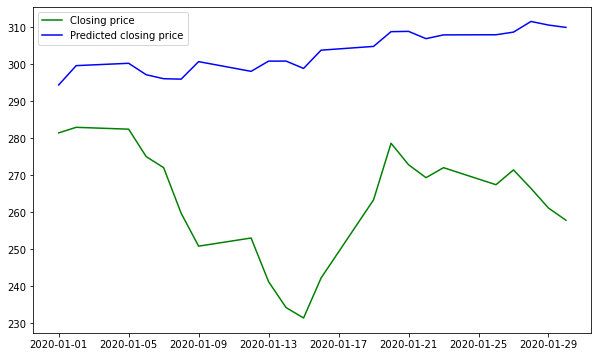

In [124]:
# Plot actual and predicted closing prices to get a better comparative view
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(result.date, result.closing_price, color="Green", label="Closing price")
ax.plot(result.date, result.predicted_closing_price, color="Blue", label="Predicted closing price")
ax.legend();

### Remarks

At this point of experiment we can see that though our model works properly, its prediction performance is not that satisfactory. This might be due to the lack of data the model is trained on. Therefore, as the next step of experiment we will increase the size of training dataset and tune some of the hyperparameters as well.